In [32]:
import csv
import gzip
import json
import jsonlines
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
from tqdm import tqdm

from document_preprocessor import RegexTokenizer
from indexing import Indexer, IndexType
from ranker import Ranker, BM25, PersonalizedBM25
from network_features import NetworkFeatures
from l2r import CrossEncoderScorer, L2RFeatureExtractor, L2RRanker
from relevance import run_relevance_tests
from vector_ranker import VectorRanker

In [2]:
DRIVE_PATH = '../data/'
CACHE_PATH = '../cache/'
STOPWORD_PATH = DRIVE_PATH + 'stopwords.txt'
DATASET_PATH = DRIVE_PATH + 'wikipedia_200k_dataset.jsonl.gz'
EDGELIST_PATH = DRIVE_PATH + 'edgelist.csv.gz'
NETWORK_STATS_PATH = DRIVE_PATH + 'network_stats.csv'
DOC2QUERY_PATH = DRIVE_PATH + 'doc2query.csv'
MAIN_INDEX = 'main_index_augmented'
TITLE_INDEX = 'title_index'
RELEVANCE_TRAIN_DATA = DRIVE_PATH + 'hw4_relevance.train.csv'
ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA = DRIVE_PATH + \
    'wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy'
PERSON_ATTRIBUTES = DRIVE_PATH + 'person-attributes.csv'
DOCUMENT_IDS = DRIVE_PATH + 'document-ids.txt'
PERSONALIZATION_PATH = DRIVE_PATH + 'personalization.jsonl'
RELEVANCE_TEST_DATA = DRIVE_PATH + 'hw4_relevance.test.csv'

In [3]:
# Load in the stopwords

stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 543'

In [4]:
# Get the list of categories for each page (either compute it or load the pre-computed list)
file_path = CACHE_PATH + 'docid_to_categories.pkl'
if not os.path.exists(file_path):
    docid_to_categories = {}
    with gzip.open(DATASET_PATH, 'rt') as file:
        for line in tqdm(file, total=200_000):
            document = json.loads(line)
            docid_to_categories[document['docid']] = document['categories']
    pickle.dump(docid_to_categories, open(file_path, 'wb'))
else:
    docid_to_categories = pickle.load(open(file_path, 'rb'))
f'Document categories collected'

'Document categories collected'

In [5]:
# Get or pre-compute the list of categories at least the minimum number of times (specified in the homework)
category_counts = Counter()
for cats in tqdm(docid_to_categories.values(), total=len(docid_to_categories)):
    for c in cats:
        category_counts[c] += 1
recognized_categories = set(
    [cat for cat, count in category_counts.items() if count >= 1000])
print("saw %d categories" % len(recognized_categories))

file_path = CACHE_PATH + 'doc_category_info.pkl'
if not os.path.exists(file_path):
    # Map each document to the smallert set of categories that occur frequently
    doc_category_info = {}
    for docid, cats in tqdm(docid_to_categories.items(), total=len(docid_to_categories)):
        valid_cats = [c for c in cats if c in recognized_categories]
        doc_category_info[docid] = valid_cats
    pickle.dump(doc_category_info, open(file_path, 'wb'))
else:
    doc_category_info = pickle.load(open(file_path, 'rb'))

  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [00:00<00:00, 562934.13it/s]


saw 118 categories


In [6]:
doc_augment_dict = defaultdict(lambda: [])
with open(DOC2QUERY_PATH, 'r', encoding='utf-8') as file:
    dataset = csv.reader(file)
    for idx, row in tqdm(enumerate(dataset), total=600_000):
        if idx == 0:
            continue
        doc_augment_dict[int(row[0])].append(row[2])

600001it [00:00, 878426.84it/s]                            


In [7]:
# Load or build Inverted Indices for the documents' main text and titles
#
# Estiamted times:
#    Document text token counting: 4 minutes
#    Document text indexing: 5 minutes
#    Title text indexing: 30 seconds
preprocessor = RegexTokenizer('\w+')

# Creating and saving the index

# main_index_path = CACHE_PATH + MAIN_INDEX
main_index = Indexer.create_index(
    IndexType.InvertedIndex, DATASET_PATH, preprocessor,
    stopwords, 50, doc_augment_dict=doc_augment_dict)
# main_index.save(main_index_path)
                
# title_index_path = CACHE_PATH + TITLE_INDEX
title_index = Indexer.create_index(             
    IndexType.InvertedIndex, DATASET_PATH, preprocessor,
    stopwords, 2, text_key='title')
# title_index.save(title_index_path)

Indexing...


100%|██████████| 200000/200000 [02:48<00:00, 1183.82it/s]


Indexing...


100%|██████████| 200000/200000 [00:16<00:00, 12033.14it/s]


In [8]:
with open(RELEVANCE_TRAIN_DATA, 'r', encoding='utf-8') as file:
    data = csv.reader(file)
    train_queries = []
    train_docs = []
    for idx, row in tqdm(enumerate(data)):
        if idx == 0:
            continue
        if row[0] not in train_queries:
            train_queries.append(row[0])
        if row[2] not in train_docs:
            train_docs.append(row[2])

9605it [00:00, 51618.05it/s]


In [9]:
# create the raw text dictionary by going through the wiki dataset
# this dictionary should store only the first 500 characters of the raw documents text

file_path = CACHE_PATH + 'raw_text_dict_train.pkl'
if not os.path.exists(file_path):
    raw_text_dict = {}
    file = gzip.open(DATASET_PATH, 'rt')
    with jsonlines.Reader(file) as reader:
        for _ in tqdm(range(200_000)):
            try:
                data = reader.read()
                if str(data['docid']) in train_docs:
                    raw_text_dict[int(data['docid'])] = data['text'][:500]
            except EOFError:
                break
    pickle.dump(raw_text_dict, open(file_path, 'wb'))
else:
    raw_text_dict = pickle.load(open(file_path, 'rb'))

In [10]:
network_features = {}
# Get or load the network statistics for the Wikipedia link network

if not os.path.exists(NETWORK_STATS_PATH):
    nf = NetworkFeatures()
    print('loading network')
    graph = nf.load_network(EDGELIST_PATH, total_edges=92650947)
    print('getting stats')
    net_feats_df = nf.get_all_network_statistics(graph)
    graph = None
    print('Saving')
    net_feats_df.to_csv(NETWORK_STATS_PATH, index=False)

    print("converting to dict format")
    network_features = defaultdict(dict)
    for i, row in tqdm(net_feats_df.iterrows(), total=len(net_feats_df)):
        for col in ['pagerank', 'hub_score', 'authority_score']:
            network_features[row['docid']][col] = row[col]
    net_feats_df = None
else:
    with open(NETWORK_STATS_PATH, 'r', encoding='utf-8') as file:
        for idx, line in enumerate(file):
            if idx == 0:
                continue
            else:
                # the indexes may change depending on your CSV
                splits = line.strip().split(',')
                network_features[int(splits[0])] = {
                    'pagerank': float(splits[1]),
                    'authority_score': float(splits[2]),
                    'hub_score': float(splits[3])
                }
f'Network stats collection {len(network_features)}'

'Network stats collection 999841'

In [11]:
# Create the feature extractor. This will be used by both pipelines
cescorer = CrossEncoderScorer(raw_text_dict)
fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
                          preprocessor, stopwords, recognized_categories,
                          network_features, cescorer)

In [12]:
bm25 = BM25(main_index)
ranker = Ranker(main_index, preprocessor, stopwords, bm25, raw_text_dict)

pipeline = L2RRanker(main_index, title_index,
                       preprocessor, stopwords, ranker, fe)
pipeline.train(RELEVANCE_TRAIN_DATA, 'model')

Loading training data...
Training model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 123


In [13]:
scores = []

In [14]:
scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, ranker))
print(f'BM25 scores: {scores[0]}')
print("MAP: ", scores[0]['map'])
print("NDCG: ", scores[0]['ndcg'])

Running relevance tests...


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [01:35<00:00,  2.57s/it]

MAP:  [0.025, 0.05, 0.19285714285714287, 0, 0, 0.26, 0.01, 0, 0.02, 0, 0.11333333333333333, 0, 0, 0.0125, 0, 0, 0.03333333333333333, 0, 0.04857142857142857, 0, 0.16666666666666666, 0.11666666666666665, 0, 0, 0.06666666666666667, 0, 0, 0, 0, 0, 0, 0.05, 0, 0, 0, 0.15, 0]
NDCG:  [0.16720121225264192, 0.1912049197383063, 0.40771619304648515, 0.0, 0.0, 0.35738444023216115, 0.0586666388908508, 0.0, 0.13279625411320248, 0.0, 0.44115113246165355, 0.04541743105845887, 0.0, 0.0716120549175052, 0.0, 0.06617289012360779, 0.16326880032415683, 0.0, 0.24276828655853022, 0.0, 0.3293683421236114, 0.3403003929241778, 0.0613262049089608, 0.07242198498924948, 0.21928535165731325, 0.0, 0.0, 0.0, 0.054633798952207324, 0.0, 0.0, 0.2578062004518628, 0.0, 0.0, 0.17487644530347446, 0.3040695800485996, 0.13058065054168094]
BM25 scores: {'map': 0.03555662805662805, 'ndcg': 0.11594673528699186, 'map_list': [0.025, 0.05, 0.19285714285714287, 0, 0, 0.26, 0.01, 0, 0.02, 0, 0.11333333333333333, 0, 0, 0.0125, 0, 0, 0.

In [15]:
scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline))
print(f'BM25 scores: {scores[1]}')
print("MAP: ", scores[1]['map'])
print("NDCG: ", scores[1]['ndcg'])

Running relevance tests...


100%|██████████| 37/37 [02:37<00:00,  4.26s/it]

MAP:  [0, 0, 0.025, 0, 0.05, 0.3571428571428571, 0.014285714285714285, 0, 0.02, 0, 0.0665079365079365, 0, 0, 0, 0, 0.075, 0, 0, 0, 0, 0.1, 0, 0, 0, 0.05, 0, 0, 0.1, 0.014285714285714285, 0, 0, 0.1, 0, 0, 0, 0.1, 0.0125]
NDCG:  [0.15044598817525506, 0.024114774059504164, 0.12133927614758865, 0.0, 0.32809409741206513, 0.587523106887649, 0.06941992066371505, 0.0, 0.13279625411320248, 0.0, 0.25797972850121437, 0.0, 0.0, 0.0, 0.0, 0.4450994304378661, 0.0, 0.0, 0.0, 0.04462046518914338, 0.21888665798006005, 0.0, 0.04492063315887466, 0.0, 0.20342085232311144, 0.02138681585816852, 0.0, 0.19031326377064925, 0.07531155140665356, 0.0, 0.0, 0.2578062004518628, 0.0, 0.0, 0.453308352082741, 0.20271305336573306, 0.05075020367217313]
BM25 scores: {'map': 0.029316816816816815, 'ndcg': 0.1048716385312765, 'map_list': [0, 0, 0.025, 0, 0.05, 0.3571428571428571, 0.014285714285714285, 0, 0.02, 0, 0.0665079365079365, 0, 0, 0, 0, 0.075, 0, 0, 0, 0, 0.1, 0, 0, 0, 0.05, 0, 0, 0.1, 0.014285714285714285, 0, 0, 0.

In [16]:
# An initial ranking with VectorRanker with reranking done by LambdaMART optimizing NDCG
with open(ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA, 'rb') as file:
    encoded_docs = np.load(file)

vector_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5',
                             encoded_docs, list(main_index.document_metadata.keys()))
pipeline.ranker = vector_ranker

In [17]:
scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline))
print(f'BM25 scores: {scores[2]}')
print("MAP: ", scores[2]['map'])
print("NDCG: ", scores[2]['ndcg'])

Running relevance tests...


100%|██████████| 37/37 [02:44<00:00,  4.45s/it]

MAP:  [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.02, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.05709397913119477, 0.0, 0.0, 0.0, 0.35152534067883506, 0.4377205066724933, 0.06496211865470962, 0.0, 0.14843011901892328, 0.0, 0.11492845531283281, 0.0, 0.0, 0.0, 0.0, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.30356357608583323, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37983770989879656, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.02437687687687688, 'ndcg': 0.07593146714120333, 'map_list': [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.02, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0], 'ndcg_list': [0.05709397913119477, 0.0, 0.0, 0.0, 0.35152534067883506, 0.4377205066724933, 0.06496211865470962, 0.0, 0.14843011901892328, 0.0, 0.11492845531283281, 0.0, 0

In [18]:
scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline, 1, 0.9, 0.1))
print(f'BM25 scores: {scores[3]}')
print("MAP: ", scores[3]['map'])
print("NDCG: ", scores[3]['ndcg'])

Running relevance tests...


100%|██████████| 37/37 [03:43<00:00,  6.03s/it]

MAP:  [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.03333333333333333, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.05709397913119477, 0.0, 0.0, 0.0, 0.35152534067883506, 0.4377205066724933, 0.06496211865470962, 0.0, 0.1696889815282525, 0.0, 0.11492845531283281, 0.0, 0.0, 0.0, 0.0, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.30356357608583323, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41283902484683005, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.02473723723723724, 'ndcg': 0.07739795842383475, 'map_list': [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.03333333333333333, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0], 'ndcg_list': [0.05709397913119477, 0.0, 0.0, 0.0, 0.35152534067883506, 0.4377205066724933, 0.06496211865470962, 0.0, 0.1696889815282525, 0.0,

In [19]:
scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline, 1, 0.5, 0.5))
print(f'BM25 scores: {scores[4]}')
print("MAP: ", scores[4]['map'])
print("NDCG: ", scores[4]['ndcg'])

Running relevance tests...


100%|██████████| 37/37 [03:44<00:00,  6.07s/it]

MAP:  [0, 0, 0, 0, 0.1, 0.3, 0.01111111111111111, 0, 0.05, 0, 0.014285714285714285, 0, 0, 0, 0, 0.12, 0, 0, 0, 0, 0.11666666666666665, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.07204458036731731, 0.0, 0.0, 0.0, 0.2386138890269565, 0.500700828153494, 0.06147980027144358, 0.0, 0.18423040552881773, 0.0, 0.14715055944239044, 0.0, 0.0, 0.0, 0.0, 0.4122868515866667, 0.0, 0.0, 0.0, 0.0, 0.3569887631594992, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4171011469199944, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.027353067353067355, 'ndcg': 0.08175963909919469, 'map_list': [0, 0, 0, 0, 0.1, 0.3, 0.01111111111111111, 0, 0.05, 0, 0.014285714285714285, 0, 0, 0, 0, 0.12, 0, 0, 0, 0, 0.11666666666666665, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0], 'ndcg_list': [0.07204458036731731, 0.0, 0.0, 0.0, 0.2386138890269565, 0.500700828153494, 0.06147980027144358, 0.0, 0.18423040552881773, 0.0, 0.14715

In [20]:
scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline, 1, 0.1, 0.9))
print(f'BM25 scores: {scores[5]}')
print("MAP: ", scores[5]['map'])
print("NDCG: ", scores[5]['ndcg'])

Running relevance tests...


100%|██████████| 37/37 [03:44<00:00,  6.06s/it]

MAP:  [0, 0, 0, 0, 0.1, 0.3, 0, 0, 0.05, 0, 0.041666666666666664, 0, 0, 0, 0, 0.13333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.0, 0.0, 0.0, 0.0, 0.2386138890269565, 0.49866046558302285, 0.0, 0.0, 0.18423040552881773, 0.0, 0.2510409205704035, 0.0, 0.0, 0.0, 0.0, 0.43948347033847657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.08179084008773017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41470827434354435, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.025450450450450447, 'ndcg': 0.07413616453223175, 'map_list': [0, 0, 0, 0, 0.1, 0.3, 0, 0, 0.05, 0, 0.041666666666666664, 0, 0, 0, 0, 0.13333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0, 0, 0, 0, 0.1, 0], 'ndcg_list': [0.0, 0.0, 0.0, 0.0, 0.2386138890269565, 0.49866046558302285, 0.0, 0.0, 0.18423040552881773, 0.0, 0.2510409205704035, 0.0, 0.0, 0.0, 0.0, 0.43948347033847657, 0.0, 0.0

In [21]:
scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline, 5, 0.9, 0.1))
print(f'BM25 scores: {scores[6]}')
print("MAP: ", scores[6]['map'])
print("NDCG: ", scores[6]['ndcg'])

scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline, 5, 0.5, 0.5))
print(f'BM25 scores: {scores[7]}')
print("MAP: ", scores[7]['map'])
print("NDCG: ", scores[7]['ndcg'])

scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline, 5, 0.1, 0.9))
print(f'BM25 scores: {scores[8]}')
print("MAP: ", scores[8]['map'])
print("NDCG: ", scores[8]['ndcg'])

Running relevance tests...


100%|██████████| 37/37 [03:42<00:00,  6.02s/it]


MAP:  [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.02, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.10627205596906898, 0.0, 0.0, 0.0, 0.2386138890269565, 0.4377205066724933, 0.06496211865470962, 0.0, 0.14843011901892328, 0.0, 0.11492845531283281, 0.0, 0.0, 0.0, 0.0, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.30356357608583323, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37983770989879656, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.02437687687687688, 'ndcg': 0.07420894349758159, 'map_list': [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.02, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0], 'ndcg_list': [0.10627205596906898, 0.0, 0.0, 0.0, 0.2386138890269565, 0.4377205066724933, 0.06496211865470962, 0.0, 0.14843011901892328, 0.0, 0.11492845531283281, 0.0, 0.0

100%|██████████| 37/37 [03:47<00:00,  6.15s/it]


MAP:  [0, 0, 0, 0, 0.1, 0.275, 0.016666666666666666, 0, 0.03333333333333333, 0, 0.01, 0, 0, 0, 0.01111111111111111, 0.1, 0, 0, 0, 0, 0.025, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.07204458036731731, 0.0, 0.0, 0.0, 0.2386138890269565, 0.4377205066724933, 0.07539233389643339, 0.0, 0.16545459026055942, 0.0, 0.11203759807401387, 0.0, 0.0, 0.0, 0.05335804586747371, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.10944332899003002, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.08179084008773017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4113289674896055, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.023993993993993996, 'ndcg': 0.07320505836495994, 'map_list': [0, 0, 0, 0, 0.1, 0.275, 0.016666666666666666, 0, 0.03333333333333333, 0, 0.01, 0, 0, 0, 0.01111111111111111, 0.1, 0, 0, 0, 0, 0.025, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0, 0, 0, 0, 0.1, 0], 'ndcg_list': [0.07204458036731731, 0.0, 0.0, 0.0, 0.2386138890269

100%|██████████| 37/37 [03:44<00:00,  6.06s/it]

MAP:  [0, 0, 0, 0, 0.1, 0.3, 0.016666666666666666, 0, 0.03333333333333333, 0, 0.01, 0, 0, 0, 0.01111111111111111, 0.12, 0, 0, 0.016666666666666666, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0.01111111111111111, 0, 0, 0, 0.1, 0]
NDCG:  [0.11418795826238955, 0.0, 0.0, 0.0, 0.2386138890269565, 0.49701217597997016, 0.07539233389643339, 0.0, 0.15783060299380178, 0.0, 0.11203759807401387, 0.0, 0.0, 0.0, 0.05335804586747371, 0.4122868515866667, 0.0, 0.0, 0.06110780562104336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.08179084008773017, 0.0, 0.0, 0.08132880126014379, 0.0, 0.0, 0.4113289674896055, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.025285285285285283, 'ndcg': 0.07921042411783383, 'map_list': [0, 0, 0, 0, 0.1, 0.3, 0.016666666666666666, 0, 0.03333333333333333, 0, 0.01, 0, 0, 0, 0.01111111111111111, 0.12, 0, 0, 0.016666666666666666, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0.01111111111111111, 0, 

In [22]:
scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline, 10, 0.9, 0.1))
print(f'BM25 scores: {scores[9]}')
print("MAP: ", scores[9]['map'])
print("NDCG: ", scores[9]['ndcg'])

scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline, 10, 0.5, 0.5))
print(f'BM25 scores: {scores[10]}')
print("MAP: ", scores[10]['map'])
print("NDCG: ", scores[10]['ndcg'])

scores.append(run_relevance_tests(RELEVANCE_TEST_DATA, pipeline, 10, 0.1, 0.9))
print(f'BM25 scores: {scores[11]}')
print("MAP: ", scores[11]['map'])
print("NDCG: ", scores[11]['ndcg'])

Running relevance tests...


100%|██████████| 37/37 [03:43<00:00,  6.05s/it]


MAP:  [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.02, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.10627205596906898, 0.0, 0.0, 0.0, 0.2386138890269565, 0.4377205066724933, 0.06496211865470962, 0.0, 0.14843011901892328, 0.0, 0.11492845531283281, 0.0, 0.0, 0.0, 0.0, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.30356357608583323, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4113289674896055, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.02437687687687688, 'ndcg': 0.07506005856760345, 'map_list': [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.02, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0], 'ndcg_list': [0.10627205596906898, 0.0, 0.0, 0.0, 0.2386138890269565, 0.4377205066724933, 0.06496211865470962, 0.0, 0.14843011901892328, 0.0, 0.11492845531283281, 0.0, 0.0,

100%|██████████| 37/37 [03:42<00:00,  6.02s/it]


MAP:  [0, 0, 0, 0, 0.1, 0.275, 0.02, 0, 0.05, 0, 0, 0, 0, 0, 0.01111111111111111, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.05709397913119477, 0.0, 0.0, 0.0, 0.2386138890269565, 0.4377205066724933, 0.08393298500209709, 0.0, 0.23768294269640358, 0.0, 0.051750662925253446, 0.0, 0.0, 0.0, 0.05335804586747371, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.06566599739401802, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.08179084008773017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4113289674896055, 0.20271305336573306, 0.03806265275412985]
BM25 scores: {'map': 0.023588588588588588, 'ndcg': 0.07217138635308461, 'map_list': [0, 0, 0, 0, 0.1, 0.275, 0.02, 0, 0.05, 0, 0, 0, 0, 0, 0.01111111111111111, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0, 0, 0, 0, 0.1, 0], 'ndcg_list': [0.05709397913119477, 0.0, 0.0, 0.0, 0.2386138890269565, 0.4377205066724933, 0.08393298500209709, 0.0, 0.23768294269640358, 0.0

100%|██████████| 37/37 [03:47<00:00,  6.15s/it]

MAP:  [0, 0, 0, 0.014285714285714285, 0.1, 0.33999999999999997, 0.02, 0, 0.1, 0, 0.01, 0, 0, 0, 0.01111111111111111, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0, 0, 0, 0, 0.1, 0]
NDCG:  [0.07204458036731731, 0.0, 0.0, 0.06779095235709004, 0.2386138890269565, 0.5084701761735054, 0.08393298500209709, 0.0, 0.23768294269640358, 0.0, 0.11203759807401387, 0.0, 0.0, 0.0, 0.05335804586747371, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.06566599739401802, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.08179084008773017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37983770989879656, 0.20271305336573306, 0.0163926922792914]
BM25 scores: {'map': 0.027353067353067355, 'ndcg': 0.07651238473625589, 'map_list': [0, 0, 0, 0.014285714285714285, 0.1, 0.33999999999999997, 0.02, 0, 0.1, 0, 0.01, 0, 0, 0, 0.01111111111111111, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.1, 0.016666666666666666, 0, 0, 0, 0, 0, 0, 0.1, 0], 'ndcg_list': [0.07204458036731731, 0.0, 0.0, 0.06779095

In [26]:
overall_scores = []
for idx, score in enumerate(scores):
    for item in score['map_list']:
        overall_scores.append({
            'model': idx,
            'score': item,
            'metric': 'map'
        })
    for item in score['ndcg_list']:
        overall_scores.append({
            'model': idx,
            'score': item,
            'metric': 'ndcg'
        })
overall_scores = pd.DataFrame(overall_scores)

In [27]:
overall_scores

,model,score,metric
0,0,0.025000,map
1,0,0.050000,map
2,0,0.192857,map
3,0,0.000000,map
4,0,0.000000,map
...,...,...,...
883,11,0.000000,ndcg
884,11,0.000000,ndcg
885,11,0.379838,ndcg
886,11,0.202713,ndcg


/tmp/ipykernel_15784/2501438673.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(models_list, rotation=45)


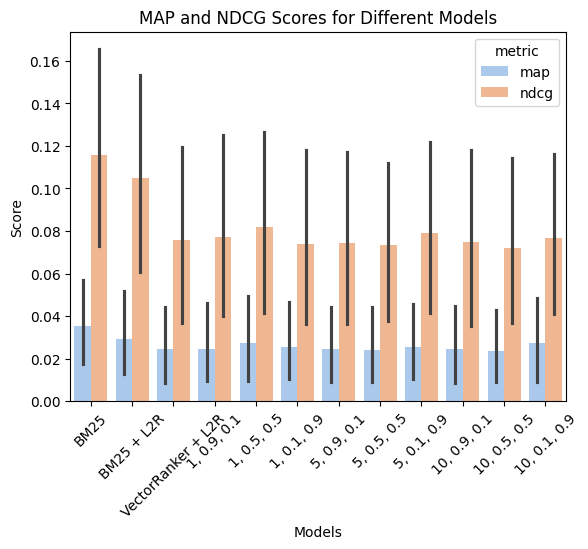

In [34]:
plot = sns.barplot(x='model', y='score', hue='metric',
                   data=overall_scores, palette='pastel')
models_list = ['BM25', 'BM25 + L2R', 'VectorRanker + L2R',
               '1, 0.9, 0.1', '1, 0.5, 0.5', '1, 0.1, 0.9',
               '5, 0.9, 0.1', '5, 0.5, 0.5', '5, 0.1, 0.9',
               '10, 0.9, 0.1', '10, 0.5, 0.5', '10, 0.1, 0.9']
plot.set_xticklabels(models_list, rotation=45)
plot.set_xlabel('Models')
plot.set_ylabel('Score')
plot.set_title('MAP and NDCG Scores for Different Models')
plt.show()